# Lab Part 1 - Steam Analysis

In [1]:
# standard library imports
import itertools
import re
import math

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# customisations
pd.set_option("max_columns", 100)
plt.style.use('default')
plt.rcdefaults()
# sns.set() # default seaborn style

In [2]:
df = pd.read_csv(
    filepath_or_buffer = 'datasets/steam/steam.csv',sep=',', decimal = ".", )
list(df.columns) 

['appid',
 'name',
 'release_date',
 'english',
 'developer',
 'publisher',
 'platforms',
 'required_age',
 'categories',
 'genres',
 'steamspy_tags',
 'achievements',
 'positive_ratings',
 'negative_ratings',
 'average_playtime',
 'median_playtime',
 'owners',
 'price']

In [3]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [4]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def get_unique_list(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x]))))

In [5]:
get_unique(df['categories'])
get_unique(df['genres'])
get_unique(df['platforms'])
get_unique(df['steamspy_tags'])



{'1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Animation & Modeling',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'Audio Production',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Controller',
 'Conversation',
 'Crafting',
 '

In [6]:
def processPlattform(df):
    plat_cols = get_unique(df['platforms'])
    
    # create a new column for each platform, with 1s indicating membership and 0s for non-members
    for col in sorted(plat_cols):
        plat_name = re.sub(r'[\s\-\/]', '_', col.lower())
        plat_name = re.sub(r'[()]', '', plat_name)
        
        df[plat_name] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)

In [7]:
def process_cat_gen_tag(df):
    """Process categories, genres, steamspy_tags and platform columns."""
    # get all unique plattform names
    plat_cols = get_unique(df['platforms'])
    
    # create a new column for each platform, with 1s indicating membership and 0s for non-members
    for col in sorted(plat_cols):
        plat_name = re.sub(r'[\s\-\/]', '_', col.lower())
        plat_name = re.sub(r'[()]', '', plat_name)
        
        df[plat_name] = df['platforms'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    # get all unique category names
    cat_cols = get_unique(df['categories'])
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])  
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    tag_cols = get_unique(df['steamspy_tags'])
    df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags','platforms'], axis=1)
    
    return df

In [8]:
def handleMultipleItemColumn(df,column,sep):
    df[column] = df[column].apply(lambda x: x.split(sep))

In [9]:
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

In [10]:
def pre_process():
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd.read_csv(filepath_or_buffer = 'datasets/steam/steam.csv',sep=',', decimal = ".")
    
    # keep lower and higher bound of owners column, as integer
    df['owners_low_bound'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    df['owners_high_bound'] = df['owners'].str.split('-').apply(lambda x: x[1]).astype(int)
    del df['owners']
    
    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)
    
    # process genres, categories and steamspy_tag columns
    #df = process_cat_gen_tag(df)
    #df['platforms_all'] = df['platforms'].apply(lambda x: mapPlatform(x))
    processPlattform(df)
    handleMultipleItemColumn(df,'platforms',';')
    handleMultipleItemColumn(df,'categories',';')
    df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])
    handleMultipleItemColumn(df,'steamspy_tags',';')
    handleMultipleItemColumn(df,'developer',';')
    handleMultipleItemColumn(df,'publisher',';')
    handleMultipleItemColumn(df,'genres',';')
    
    # Create a column to split free vs paid games
    df['type'] = 'Free'
    df.loc[df['price'] > 0, 'type'] = 'Paid'
    
    # Add Value total playtime
    df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

    # Add Value total playtime
    df['estimated_revenue'] = df.apply (lambda row: row.price*row.owners_low_bound, axis=1)

    return df

In [11]:
processedDF = pre_process()
pDF = processedDF 

In [12]:
#processedDF.head()

In [13]:
list(processedDF.columns) 
processedDF.shape

(27075, 30)

In [14]:
#processedDF.describe()

In [15]:
# Filter Games mit wenig Usernb

<AxesSubplot:>

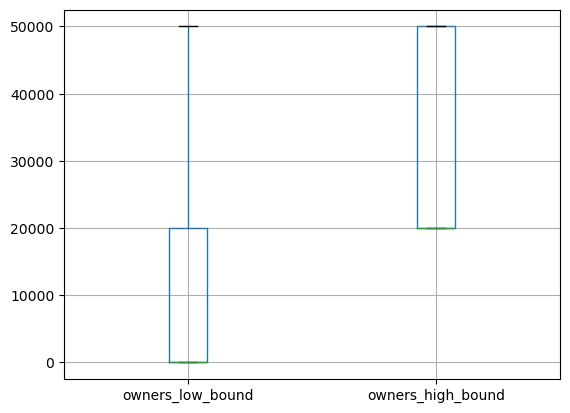

In [16]:
pDF.boxplot(column=['owners_low_bound','owners_high_bound'], return_type='axes',showfliers=False)

In [17]:
#indexNames = pDF[ pDF['owners_low_bound'] < 5000 ].index
# Delete these row indexes from dataFrame
#pDF.drop(indexNames , inplace=True)
#len(indexNames)

In [18]:
pDF.shape

(27075, 30)

Text(0.5, 1.0, 'Combination median_playtime,owners_low_bound ')

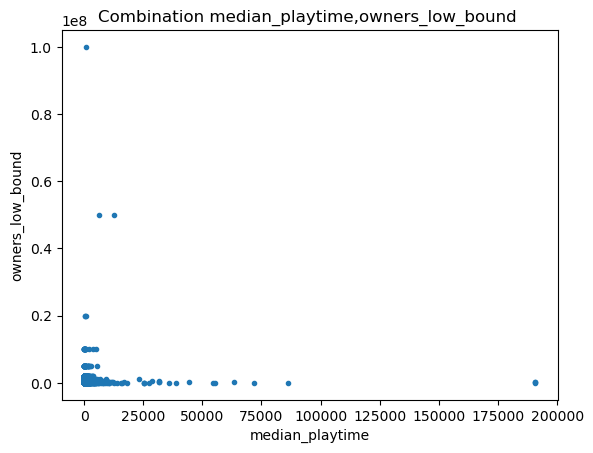

In [19]:
#Unterschied playtime vs price
xCol = 'median_playtime'
yCol = 'owners_low_bound' 


color =  np.array(['red','blue'])
plt.scatter(marker='.',x=pDF[xCol],y=pDF[yCol])
plt.xlabel(xCol)
plt.ylabel(yCol)
plt.title('Combination '+xCol+','+yCol +' ')


In [20]:
processedDF.sort_values(by='median_playtime',ascending=False)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,top_tag,type,total_playtime,estimated_revenue
9201,474030,The Abbey of Crime Extensum,2016-05-19,1,"[Manuel Pazos, Daniel Celemín]","[Manuel Pazos, Daniel Celemín]","[windows, mac, linux]",0,[Single-player],"[Adventure, Free to Play]","[Free to Play, Adventure, Retro]",0,146,22,190625,190625,0.00,50000,100000,168,0.869048,77.628930,2016,1,1,1,Free to Play,Free,9531250000,0.0
1478,219340,The Banner Saga: Factions,2013-02-25,1,[Stoic],[Versus Evil],"[windows, mac]",0,"[Multi-player, Cross-Platform Multiplayer]","[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, RPG]",42,569,202,95245,190489,0.00,200000,500000,771,0.738003,68.814073,2013,0,1,1,Free to Play,Free,19049000000,0.0
6014,380140,The Secret of Tremendous Corporation,2015-10-12,1,"[Sebastian Krzyszkowiak, Konrad Burandt, Paweł...",[dosowisko.net],"[windows, linux]",0,"[Single-player, Captions available, Steam Cloud]","[Adventure, Casual, Free to Play, Indie]","[Free to Play, Adventure, Indie]",0,218,50,95242,190445,0.00,100000,200000,268,0.813433,73.794736,2015,1,0,1,Free to Play,Free,9524200000,0.0
2023,252690,Fantasy Grounds,2014-05-09,1,"[SmiteWorks USA, LLC]","[SmiteWorks USA, LLC]","[windows, mac]",0,"[Multi-player, Co-op, Cross-Platform Multiplayer]","[Indie, RPG, Strategy]","[RPG, Strategy, Software]",0,377,100,43074,86148,29.99,20000,50000,477,0.790356,72.866781,2014,0,1,1,RPG,Paid,861480000,599800.0
23409,892420,懒人修仙传,2018-11-14,0,[托更的修罗],[托更的修罗],[windows],0,[Single-player],"[Casual, Indie, RPG, Simulation]","[Simulation, Indie, Casual]",0,404,164,43632,71857,2.89,20000,50000,568,0.711268,65.858932,2018,0,0,1,Simulation,Paid,872640000,57800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,553450,The Purge Day,2016-11-25,1,[Red Limb Studio],[Red Limb Studio ],[windows],0,"[Single-player, Steam Achievements, Full contr...","[Violent, Action, Indie]","[Indie, Action, Violent]",14,22,16,0,0,1.99,0,20000,38,0.578947,48.286340,2016,0,0,1,Indie,Paid,0,0.0
11912,553440,R.A.T.S. (Regulatory Astro-Topographical Stabi...,2017-02-15,1,[Mark Miller Studios],[I.E.D. Studios],[windows],0,"[Single-player, Steam Achievements, Partial Co...","[Action, Indie]","[Action, Indie]",9,9,2,0,0,0.00,0,20000,11,0.818182,62.456017,2017,0,0,1,Action,Free,0,0.0
11911,553430,Skill Master VR -- Learn Meditation,2016-11-21,1,"[fletcher.richman, owockitalki]",[Boulder VR Studios],[windows],0,"[Single-player, Steam Achievements]","[Indie, Early Access]","[Early Access, Indie, Casual]",9,3,2,0,0,10.99,0,20000,5,0.600000,42.506594,2016,0,0,1,Early Access,Paid,0,0.0
11910,553410,Pirate Defense,2016-11-11,1,"[Rushil Reddy, Christiane Snyder]",[Rushil Reddy],[windows],0,"[Single-player, Steam Trading Cards]",[Strategy],"[Strategy, VR, Tower Defense]",0,5,5,0,0,6.99,0,20000,10,0.500000,37.853544,2016,0,0,1,Strategy,Paid,0,0.0


In [21]:
processedDF['owners_low_bound'].median()

0.0

## Top played games
Get the top x% of Games based on User

In [22]:
percent = 50
pDF.sort_values(by='owners_low_bound',ascending=False)
numberOfTopGames = math.ceil(len(pDF.index) * percent / 100 )
print("total number",len(pDF.index))
print("top",percent,"%",numberOfTopGames)


total number 27075
top 50 % 13538


In [23]:
topPDF = pDF.sort_values(by='owners_low_bound',ascending=False).head(numberOfTopGames)

In [24]:
#topPDF

In [25]:
def scatterPlot(df,xCol,yCol,color):
    color =  np.array(['red','blue'])
    plt.scatter(marker='.',x=df[xCol],y=df[yCol])
    plt.xlabel(xCol)
    plt.ylabel(yCol)
    plt.title('Combination '+xCol+','+yCol +' ')
    

In [26]:
#scatterPlot(topPDF,'release_year','type','')

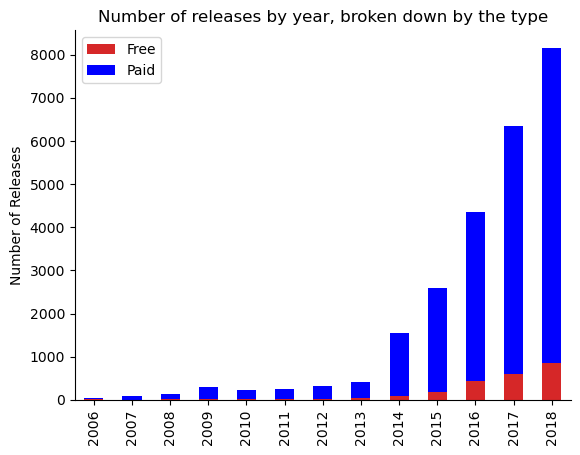

In [27]:
# Release per Year
df = pDF.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"].shape[0]
    total_gt_20k = year_df[year_df.type == "Paid"].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by the type')
sns.despine()
plt.show()

In [28]:
#df = topPDF.copy()
#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)
#topPDF.sort_values(by='total_playtime',ascending=False)

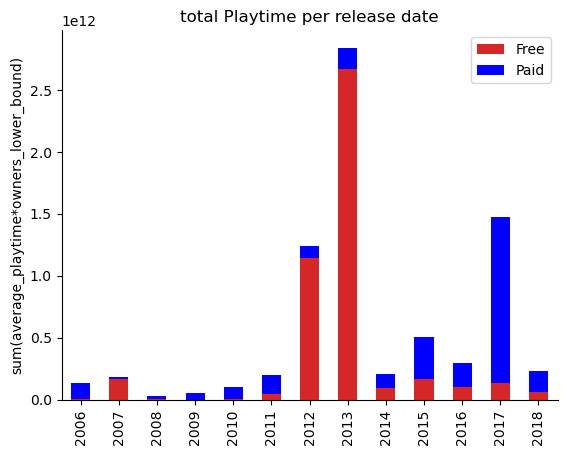

In [29]:
# Playtime ( sum(average_playtime*owners_lower_bound) ) per Year
df = pDF.copy()

#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"]['total_playtime'].sum()
    total_gt_20k = year_df[year_df.type == "Paid"]['total_playtime'].sum()
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime per release date')
sns.despine()
plt.show()

### Aussage

Es gibt ein paar Spiele die extrem populär sind und mehr spielzeit generieren als tausende andere spiele zusammen.


FREE 0.6140612525625283
PAID 0.3859387474374717


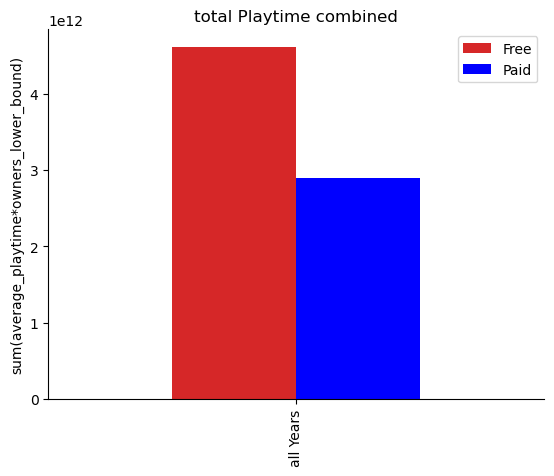

In [30]:
# Playtime ( sum(average_playtime*owners_lower_bound) ) per Year
df = pDF.copy()

#df['total_playtime'] = df.apply (lambda row: row.average_playtime*row.owners_low_bound, axis=1)

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        # very few releases in data prior to 2006, and we're still in 2019 (at time of writing)
        # so ignore these years
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df.type == "Free"]['total_playtime'].sum()
    total_gt_20k = year_df[year_df.type == "Paid"]['total_playtime'].sum()
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
    
years = ['all Years']
gesamtlt = np.sum(lt_20k)
gesamtgt = np.sum(gt_20k)

gesamtGesamt = gesamtlt + gesamtgt

print("FREE",gesamtlt / gesamtGesamt)
print("PAID",gesamtgt / gesamtGesamt)


owners_df = pd.DataFrame(zip(years, [gesamtlt], [gesamtgt]), 
                         columns=['year', 'Free', 'Paid'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=False, color=['tab:red', 'blue'])

ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime combined')
sns.despine()
plt.show()

In [31]:
pDF.sort_values(by='total_playtime',ascending=False).head(20)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,top_tag,type,total_playtime,estimated_revenue
22,570,Dota 2,2013-07-09,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Co-op, Steam Trading Cards, Ste...","[Action, Free to Play, Strategy]","[Free to Play, MOBA, Strategy]",0,863507,142079,23944,801,0.00,100000000,200000000,1005586,0.858710,85.201281,2013,1,1,1,Free to Play,Free,2394400000000,0.000000e+00
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,[PUBG Corporation],[PUBG Corporation],[windows],0,"[Multi-player, Online Multi-Player, Stats]","[Action, Adventure, Massively Multiplayer]","[Survival, Shooter, Multiplayer]",37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,Survival,Paid,1146900000000,1.349500e+09
25,730,Counter-Strike: Global Offensive,2012-08-21,1,"[Valve, Hidden Path Entertainment]",[Valve],"[windows, mac, linux]",0,"[Multi-player, Steam Achievements, Full contro...","[Action, Free to Play]","[FPS, Multiplayer, Shooter]",167,2644404,402313,22494,6502,0.00,50000000,100000000,3046717,0.867952,86.310312,2012,1,1,1,FPS,Free,1124700000000,0.000000e+00
0,10,Counter-Strike,2000-11-01,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",0,124534,3339,17612,317,7.19,10000000,20000000,127873,0.973888,95.975678,2000,1,1,1,Action,Paid,176120000000,7.190000e+07
19,440,Team Fortress 2,2007-10-10,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]","[Free to Play, Multiplayer, FPS]",520,515879,34036,8495,623,0.00,20000000,50000000,549915,0.938107,92.933233,2007,1,1,1,Free to Play,Free,169900000000,0.000000e+00
121,4000,Garry's Mod,2006-11-29,1,[Facepunch Studios],[Valve],"[windows, mac, linux]",0,"[Single-player, Multi-player, Co-op, Cross-Pla...","[Indie, Simulation]","[Sandbox, Multiplayer, Funny]",29,363721,16433,12422,1875,6.99,10000000,20000000,380154,0.956773,94.677179,2006,1,1,1,Sandbox,Paid,124220000000,6.990000e+07
1634,230410,Warframe,2013-03-25,1,[Digital Extremes],[Digital Extremes],[windows],16,"[Single-player, Multi-player, Co-op, Steam Tra...","[Action, Free to Play]","[Free to Play, Action, Co-op]",187,226541,20268,5845,394,0.00,20000000,50000000,246809,0.917880,90.695302,2013,0,0,1,Free to Play,Free,116900000000,0.000000e+00
2478,271590,Grand Theft Auto V,2015-04-13,1,[Rockstar North],[Rockstar Games],[windows],18,"[Single-player, Multi-player, Steam Achievemen...","[Action, Adventure]","[Open World, Action, Multiplayer]",77,329061,139308,9837,4834,24.99,10000000,20000000,468369,0.702568,69.567115,2015,0,0,1,Open World,Paid,98370000000,2.499000e+08
1025,72850,The Elder Scrolls V: Skyrim,2011-11-10,1,[Bethesda Game Studios],[Bethesda Softworks],[windows],16,"[Single-player, Steam Achievements, Steam Trad...",[RPG],"[Open World, RPG, Fantasy]",75,237303,14951,7089,3885,9.99,10000000,20000000,252254,0.940730,92.960488,2011,0,0,1,Open World,Paid,70890000000,9.990000e+07
4712,346110,ARK: Survival Evolved,2017-08-27,1,"[Studio Wildcard, Instinct Games, Efecto Studi...",[Studio Wildcard],"[windows, mac, linux]",0,"[Single-player, Multi-player, MMO, Co-op, Stea...","[Action, Adventure, Indie, Massively Multiplay...","[Survival, Open World, Multiplayer]",32,145035,66603,14154,1470,44.99,5000000,10000000,211638,0.685298,67.675307,2017,1,1,1,Survival,Paid,70770000000,2.249500e+08


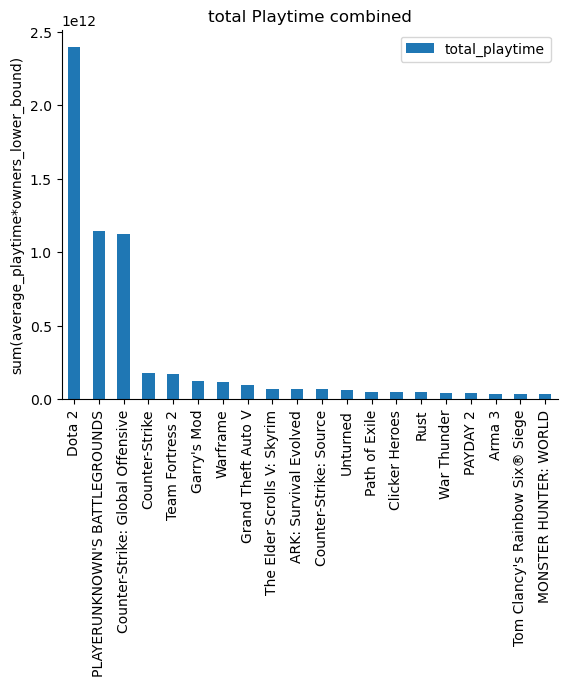

In [32]:
data = pDF.sort_values(by='total_playtime',ascending=False).head(20)

ax = data.plot(x='name', y='total_playtime', kind='bar', stacked=False)
ax.set_xlabel('')
ax.set_ylabel('sum(average_playtime*owners_lower_bound)')
ax.set_title('total Playtime combined')
sns.despine()
plt.show()

In [33]:
top3Playtime = pDF.sort_values(by='total_playtime',ascending=False).head(3)[('total_playtime')].sum()
allOtherPlaytime = pDF.sort_values(by='total_playtime',ascending=True).head((27075-3))[('total_playtime')].sum()

totalPlaytimeAll = pDF['total_playtime'].sum()
print("top3Playtime:",top3Playtime*100/totalPlaytimeAll)
print("allOtherPlaytime:",allOtherPlaytime*100/totalPlaytimeAll)



top3Playtime: 59.700122624768376
allOtherPlaytime: 40.299877375231624


## Insight 2

In [34]:
tptPDF = pDF.sort_values('total_playtime',ascending=False).head(math.ceil(27075*0.01))
tptPDF

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,top_tag,type,total_playtime,estimated_revenue
22,570,Dota 2,2013-07-09,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Co-op, Steam Trading Cards, Ste...","[Action, Free to Play, Strategy]","[Free to Play, MOBA, Strategy]",0,863507,142079,23944,801,0.00,100000000,200000000,1005586,0.858710,85.201281,2013,1,1,1,Free to Play,Free,2394400000000,0.000000e+00
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,[PUBG Corporation],[PUBG Corporation],[windows],0,"[Multi-player, Online Multi-Player, Stats]","[Action, Adventure, Massively Multiplayer]","[Survival, Shooter, Multiplayer]",37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,Survival,Paid,1146900000000,1.349500e+09
25,730,Counter-Strike: Global Offensive,2012-08-21,1,"[Valve, Hidden Path Entertainment]",[Valve],"[windows, mac, linux]",0,"[Multi-player, Steam Achievements, Full contro...","[Action, Free to Play]","[FPS, Multiplayer, Shooter]",167,2644404,402313,22494,6502,0.00,50000000,100000000,3046717,0.867952,86.310312,2012,1,1,1,FPS,Free,1124700000000,0.000000e+00
0,10,Counter-Strike,2000-11-01,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",0,124534,3339,17612,317,7.19,10000000,20000000,127873,0.973888,95.975678,2000,1,1,1,Action,Paid,176120000000,7.190000e+07
19,440,Team Fortress 2,2007-10-10,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]","[Free to Play, Multiplayer, FPS]",520,515879,34036,8495,623,0.00,20000000,50000000,549915,0.938107,92.933233,2007,1,1,1,Free to Play,Free,169900000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6433,391540,Undertale,2015-09-15,1,[tobyfox],[tobyfox],"[windows, mac, linux]",0,"[Single-player, Steam Trading Cards]","[Indie, RPG]","[Great Soundtrack, Story Rich, Choices Matter]",0,97832,4496,679,443,6.99,2000000,5000000,102328,0.956063,94.122755,2015,1,1,1,Great Soundtrack,Paid,1358000000,1.398000e+07
5553,367500,Dragon's Dogma: Dark Arisen,2016-01-15,1,[Capcom],[Capcom],[windows],0,"[Single-player, Steam Achievements, Full contr...","[Action, Adventure, RPG]","[RPG, Open World, Character Customization]",59,12856,1688,1355,1137,23.99,1000000,2000000,14544,0.883938,85.926151,2016,0,0,1,RPG,Paid,1355000000,2.399000e+07
1773,239030,"Papers, Please",2013-08-08,1,[Lucas Pope],[3909],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Steam Trad...","[Adventure, Indie]","[Indie, Political, Simulation]",13,25587,1103,674,214,6.99,2000000,5000000,26690,0.958674,93.638047,2013,1,1,1,Indie,Paid,1348000000,1.398000e+07
357,15370,Heroes of Might & Magic V: Tribes of the East,2008-10-10,1,[Nival],[Ubisoft],[windows],0,[Single-player],[Strategy],"[Strategy, Turn-Based Strategy, Turn-Based]",0,759,66,6679,6679,8.59,200000,500000,825,0.920000,85.909410,2008,0,0,1,Strategy,Paid,1335800000,1.718000e+06


In [35]:
pDF.sort_values(by='estimated_revenue',ascending=False).head(20)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,top_tag,type,total_playtime,estimated_revenue
12836,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,1,[PUBG Corporation],[PUBG Corporation],[windows],0,"[Multi-player, Online Multi-Player, Stats]","[Action, Adventure, Massively Multiplayer]","[Survival, Shooter, Multiplayer]",37,496184,487076,22938,12434,26.99,50000000,100000000,983260,0.504632,50.066901,2017,0,0,1,Survival,Paid,1146900000000,1.349500e+09
12965,582010,MONSTER HUNTER: WORLD,2018-08-09,1,"[CAPCOM Co., Ltd.]","[CAPCOM Co., Ltd.]",[windows],0,"[Single-player, Multi-player, Co-op, Steam Ach...",[Action],"[Action, Hunting, Multiplayer]",50,72029,35294,6512,5372,49.99,5000000,10000000,107323,0.671142,66.087643,2018,0,0,1,Action,Paid,32560000000,2.499500e+08
2478,271590,Grand Theft Auto V,2015-04-13,1,[Rockstar North],[Rockstar Games],[windows],18,"[Single-player, Multi-player, Steam Achievemen...","[Action, Adventure]","[Open World, Action, Multiplayer]",77,329061,139308,9837,4834,24.99,10000000,20000000,468369,0.702568,69.567115,2015,0,0,1,Open World,Paid,98370000000,2.499000e+08
4712,346110,ARK: Survival Evolved,2017-08-27,1,"[Studio Wildcard, Instinct Games, Efecto Studi...",[Studio Wildcard],"[windows, mac, linux]",0,"[Single-player, Multi-player, MMO, Co-op, Stea...","[Action, Adventure, Indie, Massively Multiplay...","[Survival, Open World, Multiplayer]",32,145035,66603,14154,1470,44.99,5000000,10000000,211638,0.685298,67.675307,2017,1,1,1,Survival,Paid,70770000000,2.249500e+08
22458,863550,HITMAN™ 2,2018-11-13,1,[IO Interactive A/S],[Warner Bros Interactive Entertainment],[windows],0,"[Single-player, Online Multi-Player, Online Co...",[Action],"[Stealth, Action, Assassin]",125,10814,1756,636,514,44.99,5000000,10000000,12570,0.860302,83.520727,2018,0,0,1,Stealth,Paid,3180000000,2.249500e+08
2016,252490,Rust,2018-02-08,1,[Facepunch Studios],[Facepunch Studios],"[windows, mac]",18,"[Multi-player, Online Multi-Player, MMO, Co-op...","[Action, Adventure, Indie, Massively Multiplay...","[Survival, Crafting, Multiplayer]",48,220370,53709,9352,2234,27.79,5000000,10000000,274079,0.804038,79.476392,2018,0,1,1,Survival,Paid,46760000000,1.389500e+08
2964,292030,The Witcher® 3: Wild Hunt,2015-05-18,1,[CD PROJEKT RED],[CD PROJEKT RED],[windows],0,"[Single-player, Steam Achievements, Full contr...",[RPG],"[Open World, RPG, Story Rich]",78,202930,4798,3068,2002,24.99,5000000,10000000,207728,0.976902,96.465364,2015,0,0,1,Open World,Paid,15340000000,1.249500e+08
2087,255710,Cities: Skylines,2015-03-10,1,[Colossal Order Ltd.],[Paradox Interactive],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Steam Trad...","[Simulation, Strategy]","[City Builder, Simulation, Building]",97,67553,6005,3225,444,22.99,5000000,10000000,73558,0.918364,90.262459,2015,1,1,1,City Builder,Paid,16125000000,1.149500e+08
2878,289070,Sid Meier’s Civilization® VI,2016-10-20,1,"[Firaxis Games, Aspyr (Mac), Aspyr (Linux)]","[2K, Aspyr (Mac), Aspyr (Linux)]","[windows, mac, linux]",0,"[Single-player, Multi-player, Steam Achievemen...",[Strategy],"[Strategy, Turn-Based Strategy, Historical]",241,39127,18325,3371,2390,49.99,2000000,5000000,57452,0.681038,66.846489,2016,1,1,1,Strategy,Paid,6742000000,9.998000e+07
5916,377160,Fallout 4,2015-11-09,1,[Bethesda Game Studios],[Bethesda Softworks],[windows],18,"[Single-player, Steam Achievements, Full contr...",[RPG],"[Open World, Post-apocalyptic, Exploration]",84,110376,45377,4822,2904,19.99,5000000,10000000,155753,0.708661,69.897041,2015,0,0,1,Open World,Paid,24110000000,9.995000e+07


Text(0.5, 1.0, 'Combination total_playtime,rating ')

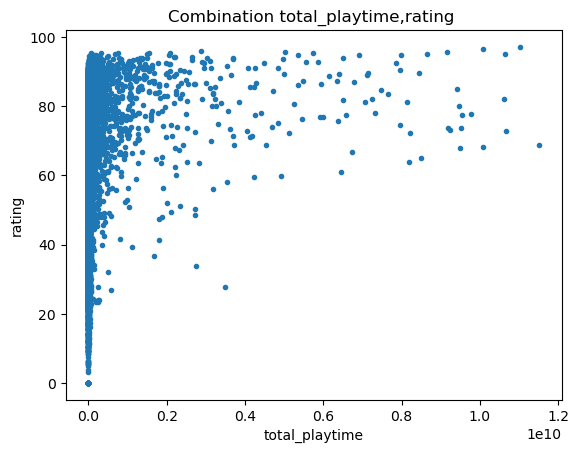

In [36]:
xCol = 'total_playtime'
yCol = 'rating' 

#data = pDF.sort_values(by='estimated_revenue',ascending=False).head(1)
data = topPDF.sort_values(by='total_playtime',ascending=True).head(len(topPDF.index)-50)

color =  np.array(['red','blue'])
plt.scatter(marker='.',x=data[xCol],y=data[yCol])
plt.xlabel(xCol)
plt.ylabel(yCol)
plt.title('Combination '+xCol+','+yCol +' ')

In [37]:
pDF[['total_playtime','type']]

,total_playtime,type
0,176120000000,Paid
1,1385000000,Paid
2,935000000,Paid
3,1290000000,Paid
4,3120000000,Paid
...,...,...
27070,0,Paid
27071,0,Paid
27072,0,Paid
27073,0,Paid


In [38]:
# IDEE:Scatter plot mit ratings * playtime rank, color: Playtime Gruppen (top 25,50, ...)
# je besser das rating desto höher ist das rating 

In [39]:
topRatedGames = pDF.sort_values(by='rating',ascending=False).head(math.ceil(27000*0.1))

In [40]:
topRatedGamesGrouped = topRatedGames[['release_year','appid']].groupby('release_year').count()
allGamesPerYear = pDF[['release_year','appid']].groupby('release_year').count()
topRatedGamesGrouped

merged = allGamesPerYear
merged['released games'] = merged['appid']
merged['top 10% rated games'] = topRatedGamesGrouped['appid']
merged['percent'] = merged['top 10% rated games'] * 100 / merged['released games']
del merged['appid']
#merged

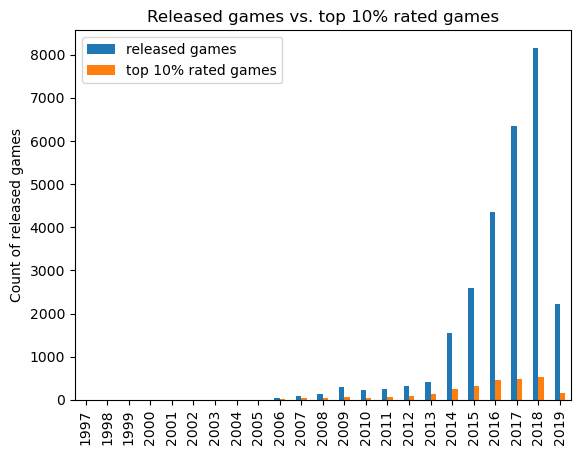

In [41]:
ax = merged.plot(y=['released games','top 10% rated games'], kind='bar', stacked=False)
ax.set_xlabel('')
ax.set_ylabel('Count of released games')
ax.set_title('Released games vs. top 10% rated games')
plt.show()

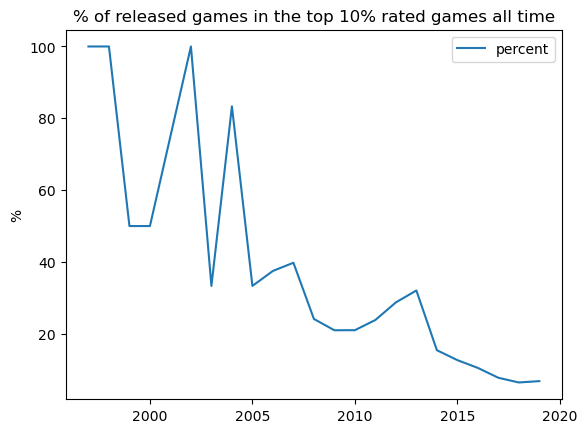

In [42]:
ax = merged.plot(y=['percent'])
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('% of released games in the top 10% rated games all time')
plt.show()

Text(0.5, 1.0, 'Combination release_date,rating ')

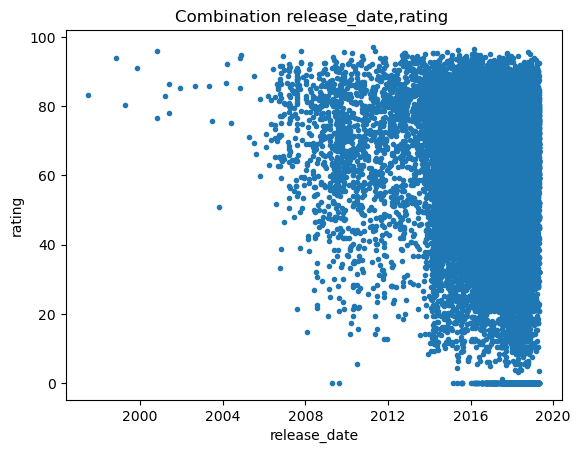

In [43]:
xCol = 'release_date'
yCol = 'rating' 

#data = pDF.sort_values(by='estimated_revenue',ascending=False).head(1)
#data = topPDF.sort_values(by='total_playtime',ascending=True).head(len(topPDF.index)-50)

plt.scatter(marker='.',x=pDF[xCol],y=pDF[yCol])
plt.xlabel(xCol)
plt.ylabel(yCol)
plt.title('Combination '+xCol+','+yCol +' ')

In [44]:
#pDF.sort_values(by='release_date',ascending=True)['release_date'][0]

In [45]:
# Regression Test
import statsmodels.api as sm

df = pDF.copy()

df['releaseDate_days_since'] = (df.release_date - pd.to_datetime('1997-06-30') ).astype('timedelta64[D]')
#df.index = pd.to_datetime(df.release_date)
#df.index.to_pydatetime() 

#x = df['release_year']
#y = df['rating']
#x = sm.add_constant(x) # adding a constant

#model = sm.OLS(y, df.index).fit()
#predictions = model.predict(x) 

#print_model = model.summary()
#print(print_model)
#df
#x = np.arange(pDF['release_date'].size)
#fit = np.polyfit(df['releaseDate_days_since'],pDF['rating'],1)
#fit_fn = np.poly1d(fit)

#plt.plot(pDF['release_year'], fit_fn(x), 'k-')
#plt.plot(pDF['release_date'], pDF['rating'], 'go', ms=2)

## Insight3

In [46]:
# Zusammenhang developer/publisher zu rating

In [47]:
windowsCount = pDF[['windows']].groupby(['windows']).sum()

<AxesSubplot:>

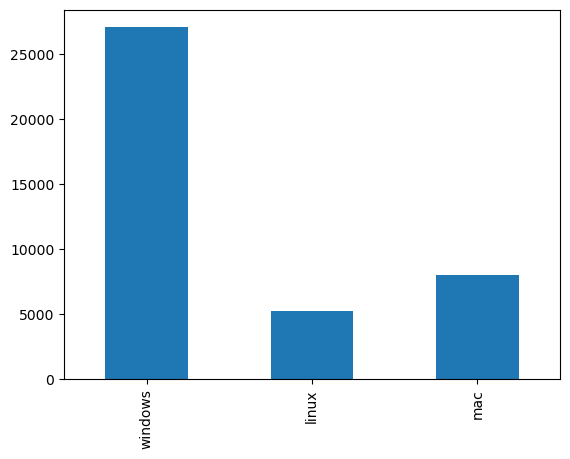

In [48]:
pDF[['windows','linux','mac']].sum().plot(kind='bar', stacked=False)

In [49]:
def andFilter(row,column,values):
    return set(values).issubset(set(row[column])) 

def orFilter(row,column,values):
    return any(item in row[column] for item in values)

def notFilter(row,column,values):
    return not (any(item in row[column] for item in values))
  
def equalsFilter(row,column,values):
    return sorted(row[column]) == sorted(values)

def smallerFilter(row,column,value):
    return row[column] < value

def biggerFilter(row,column,value):
    return row[column] > value

def sameFilter(row,column,value):
    return row[column] == value

def notSameFilter(row,column,values):
    return row[column] != values

def multipleFilter(df, funcArr):
    erg = df
    for func in funcArr:
        erg = erg[erg.apply(lambda row: func(row), axis=1)]
    return erg


#multipleFilter(pDF,[
#    lambda row: orFilter(row,'platforms',['linux','mac']),
#    lambda row: biggerFilter(row,'owners_low_bound',0),
#    lambda row: smallerFilter(row,'price',5),
#    lambda row: orFilter(row,'categories',['Single-player']),
#    lambda row: notFilter(row,'categories',['Multi-player']),
#])


    #return df[df.apply(lambda row: func(row), axis=1)]

#multipleFilter(pDF,[
#    lambda row: orFilter(row,'categories',['Single-player']),
#    lambda row: equalsFilter(row,'platforms',['windows','linux','mac'])
#])

#pDF[pDF.apply(lambda row: orFilter(row,'categories',['Single-player']), axis=1)]

#pDF[pDF.apply(lambda row: andFilter(row,'platforms',['windows','linux','mac']), axis=1)]
#pDF[pDF.apply(lambda row: orFilter(row,'platforms',['linux','mac']), axis=1)]
#pDF[pDF.apply(lambda row: isFilter(row,'platforms',['mac','windows']), axis=1)]


In [50]:
def getAllCombinations(stuff):
    erg = []
    for L in range(0, len(stuff)+1):
        for subset in itertools.combinations(stuff, L):
            erg.insert(0,list(subset))
    erg.pop()
    return erg

getAllCombinations(['windows','linux','mac'])

[['windows', 'linux', 'mac'],
 ['linux', 'mac'],
 ['windows', 'mac'],
 ['windows', 'linux'],
 ['mac'],
 ['linux'],
 ['windows']]

In [51]:
multipleFilter(pDF,[
    lambda row: orFilter(row,'platforms',['linux','mac']),
    lambda row: orFilter(row,'categories',['Single-player']),
    lambda row: notFilter(row,'categories',['Multi-player']),
    lambda row: biggerFilter(row,'price',5),
    
])

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,owners_low_bound,owners_high_bound,total_ratings,rating_ratio,rating,release_year,linux,mac,windows,top_tag,type,total_playtime,estimated_revenue
9,220,Half-Life 2,2004-11-16,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Steam Trad...",[Action],"[FPS, Action, Sci-fi]",33,67902,2419,691,402,7.19,10000000,20000000,70321,0.965601,94.882618,2004,1,1,1,FPS,Paid,6910000000,71900000.0
16,380,Half-Life 2: Episode One,2006-06-01,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Captions a...",[Action],"[FPS, Action, Sci-fi]",13,7908,517,281,184,5.79,5000000,10000000,8425,0.938635,90.775077,2006,1,1,1,FPS,Paid,1405000000,28950000.0
17,400,Portal,2007-10-10,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Captions a...",[Action],"[Puzzle, First-Person, Singleplayer]",15,51801,1080,288,137,7.19,10000000,20000000,52881,0.979577,96.103502,2007,1,1,1,Puzzle,Paid,2880000000,71900000.0
18,420,Half-Life 2: Episode Two,2007-10-10,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Single-player, Steam Achievements, Captions a...",[Action],"[FPS, Action, Sci-fi]",22,13902,696,354,301,5.79,5000000,10000000,14598,0.952322,92.576592,2007,1,1,1,FPS,Paid,1770000000,28950000.0
23,620,Portal 2,2011-04-18,1,[Valve],[Valve],"[windows, mac, linux]",0,"[Single-player, Co-op, Steam Achievements, Ful...","[Action, Adventure]","[Puzzle, Co-op, First-Person]",51,138220,1891,1102,520,7.19,10000000,20000000,140111,0.986504,97.257760,2011,1,1,1,Puzzle,Paid,11020000000,71900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26983,1052480,Adecke - Cards Games Deluxe,2019-04-20,1,[Philippe Pelchat],[Philippe Pelchat],"[windows, mac, linux]",12,[Single-player],[Casual],[Casual],0,3,1,0,0,7.19,0,20000,4,0.750000,51.899556,2019,1,1,1,Casual,Paid,0,0.0
27035,1057710,Funny Bunny: Adventures,2019-04-24,1,[mPower Games Studio],[mPower Games Studio],"[windows, mac, linux]",0,"[Single-player, Steam Achievements]","[Action, Adventure, Casual, Indie]","[Casual, Adventure, Arcade]",22,3,0,0,0,7.19,0,20000,3,1.000000,67.059371,2019,1,1,1,Casual,Paid,0,0.0
27049,1059710,New Yankee 6: In Pharaoh's Court,2019-04-03,1,[Yustas Game Studio],[Alawar Entertainment],"[windows, mac]",0,"[Single-player, Steam Cloud]","[Adventure, Casual, Indie]","[Indie, Casual, Adventure]",0,2,0,0,0,5.19,0,20000,2,1.000000,64.079515,2019,0,1,1,Indie,Paid,0,0.0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,[Yustas Game Studio],[Alawar Entertainment],"[windows, mac]",0,"[Single-player, Steam Cloud]","[Adventure, Casual, Indie]","[Indie, Casual, Adventure]",0,2,0,0,0,5.19,0,20000,2,1.000000,64.079515,2019,0,1,1,Indie,Paid,0,0.0


In [52]:
multipleFilter(pDF,[
    lambda row: orFilter(row,'platforms',['linux','mac']),
    lambda row: orFilter(row,'categories',['Multi-player']),
    lambda row: notFilter(row,'categories',['Single-player'])
])[['price','release_date','average_playtime','rating','total_playtime','estimated_revenue']].mean(numeric_only=False)


price                                      4.21983
release_date         2016-04-16 15:35:41.772151808
average_playtime                              1472
rating                                     63.5337
total_playtime                         17336775611
estimated_revenue                      2.75237e+06
dtype: object

In [53]:
avgColumns = ['price','release_date','average_playtime','rating','total_playtime','estimated_revenue']
linuxMacResult = multipleFilter(pDF,[
    lambda row: orFilter(row,'platforms',['linux','mac'])
])[avgColumns].mean(numeric_only=False)

windowsResult = multipleFilter(pDF,[
    lambda row: orFilter(row,'platforms',['windows'])
])[avgColumns].mean(numeric_only=False)

windowsResult.to_frame(name='windowsResult').transpose()

#[windowsResult,linuxMacResult].to_frame(name='windowsResult').transpose()
pd.concat([windowsResult,linuxMacResult], axis=1,keys=['a','b']).transpose()


,price,release_date,average_playtime,rating,total_playtime,estimated_revenue
a,6.07851,2016-12-31 15:01:52.508311808,149,58.8302,288722916,695414
b,6.2246,2016-09-29 10:24:19.582805248,233,64.1915,610963671,982496


In [67]:
def splitList(list):
    erg = []
    for elem in list:
        erg.insert(len(erg),[elem])
    return erg


def getStatsDataFrame(df,columnname,combinations,filterType,ergType):
    avgColumns = ['price','release_date','average_playtime','rating','total_playtime','estimated_revenue','owners_low_bound','owners_high_bound']
    series = []
    names = []
    for combination in combinations:
        if(filterType=='equals'):
            filterErg = multipleFilter(df,[
                              lambda row: equalsFilter(row,columnname,combination)
                          ])
        elif(filterType=='or'):
            filterErg = multipleFilter(df,[
                              lambda row: orFilter(row,columnname,combination)
                          ])
        elif(filterType=='and'):
            filterErg = multipleFilter(df,[
                              lambda row: andFilter(row,columnname,combination)
                          ])
        if(ergType=='mean'):  
            ser = filterErg[avgColumns].mean(numeric_only=True)
        elif(ergType=='median'):  
            ser = filterErg.median(numeric_only=True)
        elif(ergType=='sum'):  
            ser = filterErg[avgColumns].sum(numeric_only=True)
        elif(ergType=='var'):  
            ser = filterErg[avgColumns].var(numeric_only=True)
        ser['count'] = filterErg['appid'].count()
        names.insert(len(names)-1,(','.join(combination))+" ("+str(ser['count'])+")")
        series.insert(len(series)-1,ser)

    erg = pd.concat(series, axis=1,keys=names).transpose().fillna(0)
    return erg

#platformStats = getStatsDataFrame(pDF,'platforms',getAllCombinations(['windows','linux','mac']),'equals','mean')

In [55]:
#ax = platformStats['dataValues'].plot(kind='bar', stacked=False)
#ax.set_ylabel("Number of games")
#ax.set_title("Distribution of games along the different platforms")
#ax

In [56]:
#col = avgColumns[5]
#ax = platformStats[col].plot(kind='bar', stacked=False)
#ax.set_ylabel("mean_"+col)
#ax

#simplePlatformStatsSum = getStatsDataFrame(pDF,
                                        'platforms',
                                        [['windows'],['linux'],['mac']] ,
                                        'or',
                                        'sum'
                                       )

#simplePlatformStatsMean = getStatsDataFrame(pDF,
                                        'platforms',
                                        [['windows'],['linux'],['mac']] ,
                                        'or',
                                        'mean'
                                       )
#simplePlatformStatsSum

In [57]:
#col = avgColumns[0]
#ax = simplePlatformStatsMean['dataValues'].plot(kind='bar', stacked=False)
#ax.set_ylabel("Number of games")
#ax.set_title("Distribution of games along the different platforms")
#ax

preFilteredDF = multipleFilter(pDF,[
    lambda row: equalsFilter(row,'platforms',['mac']),
    lambda row: biggerFilter(row,'owners_low_bound',0),
    lambda row: biggerFilter(row,'price',0),
    #lambda row: smallerFilter(row,'price',5),
    lambda row: orFilter(row,'categories',['Single-player']),
    lambda row: notFilter(row,'categories',['Multi-player']),
])

stats = getStatsDataFrame(preFilteredDF,'categories',
                  [['Single-player'],['Multi-player']],
                  'or','mean')

ax = stats['total_playtime'].plot(kind='bar', stacked=False)
ax.set_ylabel('total_playtime')
ax.set_title("Distribution")
ax#geht nicht

,price,release_date,average_playtime,rating,total_playtime,estimated_revenue,owners_low_bound,owners_high_bound,count
Online Co-op (513),9.631813,2017-03-21 07:48:46.315789568,811,67.576853,978238849,3.608042e+06,456413,1003021,513
Full controller support (2071),10.309324,2016-01-03 06:43:58.725253376,368,72.562013,340035176,3.660316e+06,265668,581265,2071
Steam Turn Notifications (25),6.889200,2015-11-25 10:33:36.000000000,212,69.003282,24655200,8.063720e+05,108400,232000,25
Multi-player (1979),8.860258,2014-11-06 03:29:33.623042048,701,66.737500,1078476417,4.125670e+06,461793,1004396,1979
Steam Achievements (5027),8.356344,2015-11-27 23:57:42.502486528,431,69.828067,437884030,2.598881e+06,249100,545573,5027
Steam Trading Cards (4542),7.678807,2015-11-29 21:33:12.602377728,440,67.700244,430497038,2.367989e+06,250409,553985,4542
Steam Leaderboards (1341),8.357845,2015-05-24 03:31:32.617449728,404,71.648729,204085108,2.303937e+06,195667,430686,1341
Includes Source SDK (26),3.426154,2012-01-21 18:27:41.538461440,1206,79.838277,5644176923,1.838711e+07,3320000,6767307,26
Steam Cloud (3075),10.094407,2015-08-08 12:02:06.439024384,431,72.861583,422206930,3.417318e+06,266504,585983,3075
Stats (700),6.956900,2015-07-20 23:35:18.857142784,540,69.585805,910081700,2.766722e+06,371228,824571,700


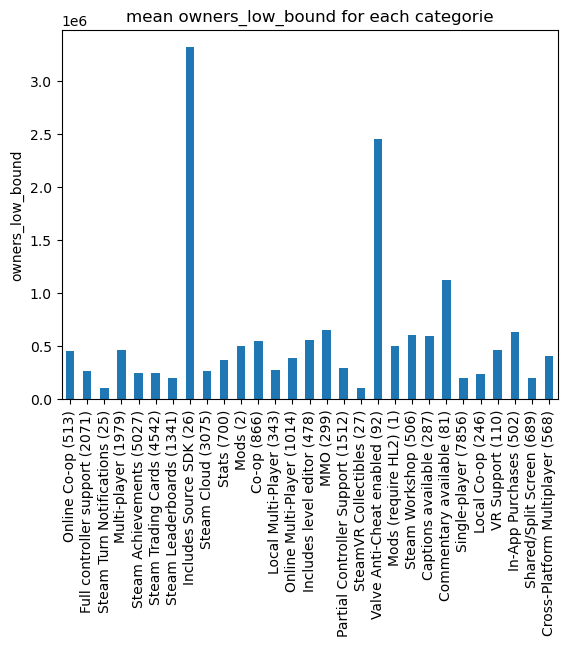

In [58]:
preFilteredDF = multipleFilter(pDF,[
    lambda row: biggerFilter(row,'owners_low_bound',10000),
    lambda row: notSameFilter(row,'appid',570),
    lambda row: notSameFilter(row,'appid',578080),
    lambda row: notSameFilter(row,'appid',730),
#    lambda row: notFilter(row,'developer',['Valve']),
#    lambda row: notFilter(row,'publisher',['Valve']),
    
#    lambda row: orFilter(row,'categories',['Single-player']),
#    lambda row: notFilter(row,'categories',['Multi-player']),
])
#570 578080 730

allcat = get_unique_list(pDF['categories'])

stats = getStatsDataFrame(preFilteredDF,'categories',
                  splitList(get_unique_list(pDF['categories'])),
                  'or','mean')
#stats
stats.fillna(pd.Timedelta(seconds=0))
ax = stats['owners_low_bound'].plot(kind='bar', stacked=False)
ax.set_ylabel('owners_low_bound')
ax.set_title("mean owners_low_bound for each categorie")
stats
#preFilteredDF.sort_values(by='total_playtime',ascending=False)


In [59]:
pDF.columns.tolist()

['appid',
 'name',
 'release_date',
 'english',
 'developer',
 'publisher',
 'platforms',
 'required_age',
 'categories',
 'genres',
 'steamspy_tags',
 'achievements',
 'positive_ratings',
 'negative_ratings',
 'average_playtime',
 'median_playtime',
 'price',
 'owners_low_bound',
 'owners_high_bound',
 'total_ratings',
 'rating_ratio',
 'rating',
 'release_year',
 'linux',
 'mac',
 'windows',
 'top_tag',
 'type',
 'total_playtime',
 'estimated_revenue']

In [85]:
import numpy as np
import matplotlib.pyplot as plt

#Source https://gist.github.com/geberl/c65517bf8273552486f9a8954e80ddf4
# https://stackoverflow.com/questions/24659005/radar-chart-with-multiple-scales-on-multiple-axes

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

In [97]:
stats = getStatsDataFrame(preFilteredDF,'platforms',
                  splitList(get_unique_list(pDF['platforms'])),
                  'or','mean')
stats
#stats.columns.to_list()
from sklearn import preprocessing
#stats = stats.transpose()
x = stats.values.astype(float) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
stats2 = pd.DataFrame(x_scaled)
stats
stats.loc[len(stats)] = 0
l = stats.index.to_list()
l.insert(len(l)-1,"a")
stats

,price,average_playtime,rating,total_playtime,estimated_revenue,owners_low_bound,owners_high_bound,count
windows (8475.0),7.115680,443.146667,66.879315,3.716495e+08,2.061991e+06,232375.221239,509681.415929,8475.0
mac (3257.0),7.108394,529.529321,71.410635,5.210886e+08,2.523470e+06,287301.197421,629167.945963,3257.0
linux (2245.0),7.446463,576.035189,72.396163,6.442566e+08,2.966127e+06,327256.124722,715256.124722,2245.0
3,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0


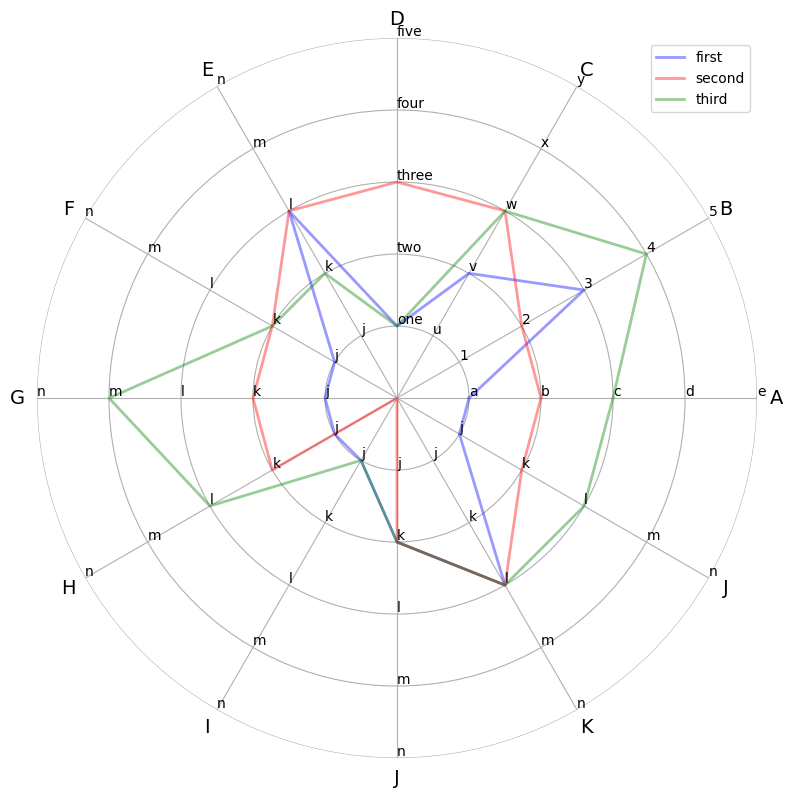

In [87]:
fig = plt.figure(figsize=(8, 8))

tit = list('ABCDEFGHIJKJ')  # 12x

lab = [
    list('abcde'),
    list('12345'),
    list('uvwxy'),
    ['one', 'two', 'three', 'four', 'five'],
    list('jklmn'),
    list('jklmn'),
    list('jklmn'),
    list('jklmn'),
    list('jklmn'),
    list('jklmn'),
    list('jklmn'),
    list('jklmn')
]

radar = Radar(fig, tit, lab)
radar.plot([1, 3, 2, 1, 3, 1, 1, 1, 1, 2, 3, 1],  '-', lw=2, color='b', alpha=0.4, label='first')
radar.plot([2, 2, 3, 3, 3, 2, 2, 2, 0, 2, 3, 2], '-', lw=2, color='r', alpha=0.4, label='second')
radar.plot([3, 4, 3, 1, 2, 2, 4, 3, 1, 2, 3, 3], '-', lw=2, color='g', alpha=0.4, label='third')
radar.ax.legend()
